# RQ4 - Can we predict an app's rating on Google Play based on its rating from Apple Store, or vice versa?

__Purpose__

In this notebook we will predict an app's google rating based on its apple rating. From such a task, we can tell those IOS developers whether they can achieve high ratings if they release their apps on Google Play.

In [1]:
from os.path import exists, isfile

import pandas as pd
import numpy as np

from matplotlib.pylab import plt
import seaborn as sns

import scipy.stats as stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score

from nltk.corpus import stopwords
from textblob import Word
from textblob import TextBlob

# Load dataset

In [2]:
if not exists("../../datasets/2300_combine_kaggle_datasets.csv"):
    print ("Missing dataset file")
    
df=pd.read_csv("../../datasets/2300_combine_kaggle_datasets.csv")
df.head()

,apple_id,trim_title,apple_title,genre,apple_rating,apple_reviews,apple_size,pegi,normed_apple_rating,google_title,...,log_google_reviews,log_apple_reviews,z_score_google_rating,z_score_apple_rating,z_score_google_sub_apple,norm_google_sub_apple,google_revenue,apple_revenue,log_google_revenue,log_apple_revenue
0,898968647,Call of Duty®,Call of Duty®: Heroes,Games,4.5,179416,201.075195,Teen,0.9,Call of Duty®: Heroes,...,6.205244,5.253861,0.449144,0.638043,-0.188899,-0.02,0.00,0.00,NaN,NaN
1,1147297267,Dont Starve,Don't Starve: Shipwrecked,Games,3.5,495,604.341797,Everyone 10+,0.7,Don't Starve: Shipwrecked,...,3.166726,2.694605,-0.143135,-0.806018,0.662884,0.12,7325.32,2470.05,3.864827,3.392706
2,352670055,F,F-Sim Space Shuttle,Games,4.5,6403,72.855469,Everyone,0.9,F-Sim Space Shuttle,...,3.734560,3.806384,0.449144,0.638043,-0.188899,-0.02,27080.73,31950.97,4.432660,4.504484
3,763692274,Grand Theft Auto,Grand Theft Auto: San Andreas,Games,4.0,32533,1964.965820,Mature 17+,0.8,Grand Theft Auto: San Andreas,...,5.542778,4.512324,0.449144,-0.083987,0.533131,0.08,2439244.38,227405.67,6.387255,5.356801
4,771989093,LEGO® Friends,LEGO® Friends,Games,4.0,400,730.941406,Everyone,0.8,LEGO® Friends,...,2.931458,2.602060,0.449144,-0.083987,0.533131,0.08,4261.46,1996.00,3.629558,3.300161


In [3]:
result_dir = '../../results/'

# Prepare the data

Before we are going to predict an app's google rating, we first decide that we will only use its apple rating, genre and pegi rating as features contributing to the predicting. This is because from the last 3 notebooks, we notice that only these 3 features have impacts on apps' ratings, but not size, price or number of reviews.

In [4]:
prediction_feature = ['google_rating']
numeric_features = ['apple_rating']

To take adcantage of features like genre and pegi rating, we have to transform these categorical features into numerical features so that we can apply linear regression model to them. We simply use one-hot encoding.

In [5]:
categorical_features= ['genre', 'pegi']
one_hot_encodings = pd.get_dummies(df[categorical_features], drop_first=True)
one_hot_encodings.shape

(604, 15)

In [6]:
one_hot_encodings.head()

,genre_Books & Reference,genre_Business,genre_Education,genre_Entertainment,genre_Food & Drink,genre_Games,genre_Health & Fitness,genre_Lifestyle,genre_News,genre_Others,genre_Social Networking,genre_Utilities,pegi_Everyone 10+,pegi_Mature 17+,pegi_Teen
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [7]:
df = pd.concat([df, one_hot_encodings], axis=1)
df.shape

(604, 40)

In [8]:
categorical_features = list(one_hot_encodings.columns)

In [9]:
base_features = numeric_features + categorical_features 
data = df[base_features + prediction_feature].copy()
data.isnull().sum()

apple_rating               0
genre_Books & Reference    0
genre_Business             0
genre_Education            0
genre_Entertainment        0
genre_Food & Drink         0
genre_Games                0
genre_Health & Fitness     0
genre_Lifestyle            0
genre_News                 0
genre_Others               0
genre_Social Networking    0
genre_Utilities            0
pegi_Everyone 10+          0
pegi_Mature 17+            0
pegi_Teen                  0
google_rating              0
dtype: int64

# Linear Regression

In [10]:
model = LinearRegression().fit(data[base_features], data[prediction_feature])
model.score(data[base_features], data[prediction_feature])

0.29905773053200035

This is a weak-moderate fit because only 30% of the variation in the target prediction is explained by training data.

# Extra feature

We have not use the title of each app yet. To take advantage of such a feature, we consider using the sentiment of it. If we have many words from apps' titles, we might be able to use methods like TF-IDF to improve our predictions by utilizing apps' titles as a new feature. However, in this project this will only lead to worse result. 

In [11]:
df['apple_title'] = df['apple_title'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['apple_title']  = df['apple_title'] .str.replace('[^\w\s]','')

In [12]:
stop = stopwords.words('english')

df['apple_title'] = df['apple_title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['apple_title'].head()

0                call duty heroes
1         dont starve shipwrecked
2              fsim space shuttle
3    grand theft auto san andreas
4                    lego friends
Name: apple_title, dtype: object

In [13]:
freq = pd.Series(' '.join(df['apple_title']).split()).value_counts()[-5:]
freq

epson        1
fightersi    1
bookstore    1
kombat       1
ok           1
dtype: int64

In [14]:
df['apple_title'] = df['apple_title'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['apple_title'].head()

0                  call duty hero
1         dont starve shipwrecked
2              fsim space shuttle
3    grand theft auto san andreas
4                     lego friend
Name: apple_title, dtype: object

In [15]:
df['sentiment'] = df['apple_title'].apply(lambda x: TextBlob(x).sentiment[0])
df['sentiment'].head()

0    0.0
1    0.0
2    0.0
3    0.5
4    0.0
Name: sentiment, dtype: float64

In [16]:
expanded_features = ['sentiment'] 

# Evaluating Predictions with Cross-Fold Validation

We choose to use median value of apps' apple ratings to predict apps' google ratings as a baseline. Also, we will see how much pegi rating, genre and title's sentiment help to predict the google ratings by making predictions only based on apps' apple ratings to make a comparison.

In [17]:
expanded_only_scores = cross_val_score(
            model, df[expanded_features], 
            data[prediction_feature], 
            cv=10,
            scoring='neg_median_absolute_error'
)

expanded_only_scores.mean()

-0.16863300998581704

In [18]:
base_scores = cross_val_score(
            model, data[base_features], 
            data[prediction_feature], 
            cv=10,
            scoring='neg_median_absolute_error'
)

base_scores.mean()

-0.13133587725815304

In [19]:
expanded_scores = cross_val_score(
            model, df[base_features+expanded_features], 
            df[prediction_feature], 
            cv=10,
            scoring='neg_median_absolute_error'
)

expanded_scores.mean()

-0.13088117589230136

In [20]:
mean_rating_scores = (df['google_rating']-df['google_rating'].median()).abs()
mean_rating_scores.mean()

0.20529801324503258

In [21]:
rating_only_scores = cross_val_score(
            model, data[['apple_rating']], 
            data[prediction_feature], 
            cv=10,                               
            scoring='neg_median_absolute_error'  
)

rating_only_scores.mean()

-0.13412837400219746

No handles with labels found to put in legend.


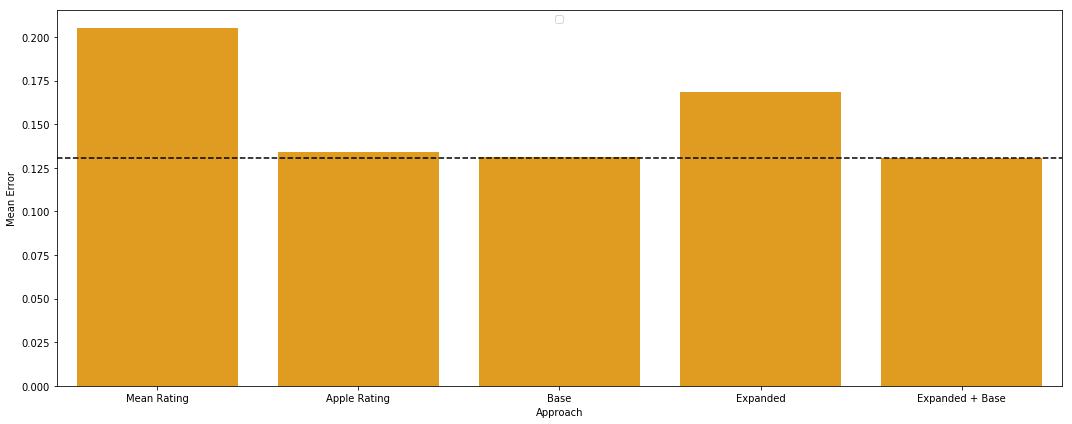

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))

error_scores = np.array([
    mean_rating_scores.mean(), -rating_only_scores.mean(), -base_scores.mean(), 
    -expanded_only_scores.mean(), -expanded_scores.mean(),
])

sns.barplot(
    ['Mean Rating', 'Apple Rating', 'Base', 'Expanded', 'Expanded + Base'],
    error_scores, color='orange', ax=ax)

ax.axhline(-expanded_scores.mean(), ls='--', c='k')

ax.set_xlabel('Approach')
ax.set_ylabel('Mean Error')
ax.legend(loc='upper center')
plt.tight_layout()

plt.savefig(result_dir + 'mean_error_graph.png')
with open(result_dir + 'mean_error_description.txt', 'w') as f:
    f.write('Mean prediction error.')

In [23]:
X = df[base_features+expanded_features].reset_index(drop=True)
y = df[prediction_feature].reset_index(drop=True)

In [24]:
kf = KFold(n_splits=10)
results = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.loc[train_index], X.loc[test_index]
    y_train, y_test = y.loc[train_index], y.loc[test_index]

    model = LinearRegression().fit(X_train, y_train)
    
    X_test['prediction'] = model.predict(X_test)
    X_test['actual'] = y_test

    results.append(X_test)

results_df = pd.concat(results)

In [25]:
results_df['abs_error'] = (results_df['prediction'] - results_df['actual']).abs()

In [26]:
results_df['abs_error'].describe()

count    604.000000
mean       0.173728
std        0.199517
min        0.000239
25%        0.062849
50%        0.127204
75%        0.221844
max        2.304984
Name: abs_error, dtype: float64

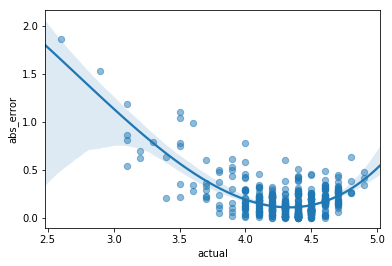

In [27]:
sns.regplot(x="actual", y="abs_error", data=results_df[results_df['actual']>2.5],scatter_kws={"s": 40, 'alpha':.5},order=3)

This model has better performance when it makes predictions for apps that have ratings in the range [4.0, 4.7].